In [2]:
import logging
 
import datetime
import pandas as pd
import os
import warnings

from PIL import Image
import numpy as np
from numpy import save, load

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, \
    GlobalMaxPool2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda, Conv2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

import cv2

from tqdm import tqdm
from collections import Counter

In [3]:
logging.basicConfig(level=logging.DEBUG)
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

In [4]:
def Get_Croped_image(img,bb_data):
    img_shape = img.shape
    x = bb_data[0]
    y = bb_data[1]
    w = bb_data[2]
    h = bb_data[3]
    crop_img = img[y:y+h, x:x+w]
    return crop_img


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    zoom_range=0.1)

def augment(im_array):
    im_array = datagen.random_transform(im_array)
    return im_array


def read_and_resize(dataFrame, input_shape=(224,224),aug=True):
    #filepath = image_data.path.values[0]
    images = []
    for index in dataFrame.index :
        im_cv = cv2.imread(dataFrame["path"][index])
        bb_data = (dataFrame["x"][index],dataFrame["y"][index],dataFrame["w"][index],dataFrame["h"][index])
        im_cv = Get_Croped_image(im_cv,bb_data)
        im_cv = cv2.resize(im_cv,input_shape)
        im_array = np.array(im_cv)
        im_cv = np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")
        if aug:
            im_cv = augment(im_cv)
        images.append(im_cv)
    return images

In [5]:

def gen(df, batch_size=4,input_shape=(224,224), aug=False):
    df = df.sample(frac=1)
    while True:
        for _, batch in enumerate([df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]):
            labels = np.array(batch.out_ages.values)

            #labels = labels[..., np.newaxis]
            labels_categorical = []
            for label in labels:
                labels_categorical.append(to_categorical(label,num_classes=99))
            labels_categorical = np.array(labels_categorical)
            #labels_categorical = labels_categorical[...,np.newaxis]
            
            #labels = labels[..., np.newaxis]    
            images = np.array(read_and_resize(batch,input_shape=input_shape,aug=aug))
            yield images, labels_categorical

In [6]:
def get_model(optimizer,n_classes=1):

    base_model = keras.applications.nasnet.NASNetMobile(weights="./NASNet-mobile-no-top.h5", include_top=False)

    #for layer in base_model.layers:
    #    layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    #x = Flatten()
    x = Dense(1000, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(750,activation="relu")(x)
    x = Dense(350,activation="relu")(x)
    #x = Dense(100,activation="relu")(x)
    x = Dropout(0.2)(x)
    if n_classes == 1:
        x = Dense(n_classes, activation="sigmoid")(x)
    else:
        x = Dense(n_classes, activation="softmax")(x)

    base_model = Model(base_model.input, x, name="base_model")
    if n_classes == 1:
        base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=optimizer)
    else:
        base_model.compile(loss="categorical_crossentropy", metrics=['acc'], optimizer=optimizer)

    return base_model

In [7]:
# def get_model(optimizer,n_classes=1):
#     model = keras.Sequential()
#     model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(256,256,3),padding='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#     model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#     model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#     model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#     model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#     model.add(GlobalAveragePooling2D())
#     #model.add()
#     #model.add(Dense(47150, activation = 'relu'))
#     #model.add(Dense(47150/2, activation = 'relu'))
#     #model.add(Dense(47150/4, activation = 'relu'))
#     #model.add(Dense(47150/8, activation = 'relu'))
#     #model.add(Dense(n_classes, activation = 'softmax'))
        
#     if n_classes == 1:
#         model.add(Dense(n_classes, activation="sigmoid"))#(x)
#     else:
#         model.add(Dense(n_classes, activation="softmax"))#(x)
#     #base_model = Model(base_model.input, x, name="base_model")
#     if n_classes == 1:
#         model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=optimizer)
#     else:
#         model.compile(loss="sparse_categorical_crossentropy", metrics=['acc'], optimizer=optimizer)

#     return model

In [8]:
if __name__ == "__main__":
    base_path = "./Dataset-copy/"

    dict_age = {'(0, 2)' : 0,
                '(3, 5)' : 1,
                '(6, 10)' : 2,
                '(11, 15)' : 3,
                '(16, 20)' : 4,
                '(21, 30)' : 5,
                '(31, 40)' : 6,
                '(41, 50)' : 7,
                '(51, 60)' : 8,
                '(61, 70)' : 9,
                '(71, 80)' : 10,
                 '(81, 90)' : 11,
                 '(91, 100)' : 12}

    bag = 3

    all_indexes = list(range(5))
    
    accuracies = []
    print("Reading train and test CSV files ")
    train_df = pd.read_csv("croped_filter_expanded_data.csv")
    #test_df = pd.read_csv("test_gender_filtered_data_with_path.csv")
    tr_tr, tr_val = train_test_split(train_df, test_size=0.1)
    tr_unique_ages = tr_tr['out_ages'].unique()
    tr_unique_ages.sort()
    #print("Unique ages are: ",val_unique_ages)
    print("Reading Done.")
    cnt_ave = 0
    predictions = 0
#     print("Extracting test labels and test images from files")
#     test_images = load("imdb_test_images.npy")
#     test_labels = load("imdb_test_labels.npy")
#     print("Extracting Done.")
    #tr_tr, tr_val = train_test_split(train_df, test_size=0.1,random_state = 100)
    file_path = "imdb_age_recog_weights.h5"
    
    print("Generating callback_list")
    
#     log_dir="./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#     tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    #early = EarlyStopping(monitor="val_acc", mode="max", patience=5)

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss",
                                          mode="min", 
                                          factor=0.1,
                                          #cooldown=0,
                                          patience=7,
                                          verbose=1,
                                          min_lr=0.00001)
    tensorboard = TensorBoard(log_dir='./logs/imdb_age_recog')

    callbacks_list = [checkpoint,
                      reduce_on_plateau,
                      tensorboard
                      #tensorboard_callback
                      #early
                     ]  # early
    
    print("Done Generating callbacklist.")
    print("generating Model")
    optimizer = Adam(lr=0.0001)
    model = get_model( optimizer,n_classes=99)
    print("Done generating model")
    print("Running Fit_generator")
    batch_size = 4
    input_shape=(224,224)
    model.fit_generator(gen(tr_tr,batch_size=batch_size, aug=True), 
                        validation_data=gen(tr_val), 
                        epochs=200, 
                        verbose=1, 
                        #workers=4,
                        callbacks=callbacks_list,
                        steps_per_epoch=int(len(tr_tr)/batch_size),#int(10740.75), 
                        validation_steps=100)
                        #validation_data=((test_images), test_labels)
                        #use_multiprocessing=True)
    #model.save(file_path)
    print("Trained Model saved  to disk")

Reading train and test CSV files 
Reading Done.
Generating callback_list
Done Generating callbacklist.
generating Model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Done generating model
Running Fit_generator


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/mnt/sda5/vamsik1211/Data/test10/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-765b02ab788d>", line 80, in <module>
    validation_steps=100)
  File "/mnt/sda5/vamsik1211/Data/test10/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1433, in fit_generator
    steps_name='steps_per_epoch')
  File "/mnt/sda5/vamsik1211/Data/test10/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_generator.py", line 178, in model_iteration
    mode=mode)
  File "/mnt/sda5/vamsik1211/Data/test10/lib/python3.7/site-packages/tensorflow/python/keras/callbacks.py", line 105, in configure_callbacks
    callback_list.set_model(callback_model)
  File "/mnt/sda5/vamsik1211/Data/test10/lib/python3.7/site-packages/tensorflow/python/keras/callbacks.py", line 231, in set_model
    callback.set_model(model)
  File

KeyboardInterrupt: 

In [8]:
model.summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_________________________________________________________________________________________

In [5]:
def Get_Croped_image(img,bb_data):
    #img_shape = img.shape
    #cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    x = bb_data[0]
    y = bb_data[1]
    w = bb_data[2]
    h = bb_data[3]
    #print(img)
    crop_img = img[y:y+h, x:x+w]
    return crop_img


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    #brightness_range=[1,1.02],
    zoom_range=0.1)

def augment(im_array):
    im_array = datagen.random_transform(im_array)
    return im_array


def read_and_resize(dataFrame, input_shape=(128,128)):
    #filepath = image_data.path.values[0]
    images = []
    for index in dataFrame.index :
        im_cv = cv2.imread(dataFrame["path"][index])
        #im_cv = cv2.cvtColor(im_cv, cv2.COLOR_RGB2GRAY)
        #cv2.imshow("image", im_cv)
        cv2.waitKey(0)
        
        
        bb_data = (dataFrame["x"][index],dataFrame["y"][index],dataFrame["w"][index],dataFrame["h"][index])
        #print(dataFrame["path"][index])
        im_cv = Get_Croped_image(im_cv,bb_data)
        im_cv = cv2.resize(im_cv,input_shape)
        im_means = cv2.mean(im_cv)
        im_array = np.array(im_cv)
        
        im_cv = np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")
        im_cv = augment(im_cv)
    
        images.append(im_cv)
        
    return images



In [17]:
# def batch(data_set, batch_size):
#     """Yield successive n-sized chunks from l."""
#     for i in range(0, len(data_set), batch_size):
#         return data_set[i:i + batch_size]



def gen(df, batch_size=4, aug=True):
    #df = df.sample(frac=1)

#     dict_age = {'(0, 2)' : 0,
#                 '(3, 5)' : 1,
#                 '(6, 10)' : 2,
#                 '(11, 15)' : 3,
#                 '(16, 20)' : 4,
#                 '(21, 30)' : 5,
#                 '(31, 40)' : 6,
#                 '(41, 50)' : 7,
#                 '(51, 60)' : 8,
#                 '(61, 70)' : 9,
#                 '(71, 80)' : 10,
#                  '(81, 90)' : 11,
#                  '(91, 100)' : 12}

    while True:
        for _, batch in enumerate([df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]):
            labels = np.array(batch.out_ages.values)

            #labels = labels[..., np.newaxis]
            labels_categorical = []
            for label in labels:
                labels_categorical.append(to_categorical(label,num_classes=100))
            labels_categorical = np.array(labels_categorical)
            if aug:
                
                images = read_and_resize(batch)
                
                
                
                    #images = np.array([augment(read_and_resize(file_path)) for file_path in batch.path.values])
#                images = []
#                 for index in range(len(batch)):
#                     print(type(batch))
#                     file_path = batch.path.values
#                     temp_img = augment(read_and_resize(batch.path.values,batch.face_loc.values))
#                     #print(temp_img.shape)
#                     images.append(temp_img)

                
    
            else:
                images = np.array([read_and_resize(file_path) for file_path in batch.path.values])


            #labels = np.array([dict_age[g] for g in batch.out_ages.values])
#             images = np.array(images)
            return images, labels_categorical

In [18]:
df = pd.read_csv("croped_filter_expanded_data.csv")

In [19]:
img = gen(df[0:5])
#cv2.destroyAllWindows()

./Dataset-copy/imdb_faces/imdb_crop/65/nm0924965_rm2828254976_1984-0-0_2004.jpg
./Dataset-copy/imdb_faces/imdb_crop/04/nm0000404_rm1126270720_1937-12-21_2010.jpg
./Dataset-copy/imdb_faces/imdb_crop/23/nm0000323_rm673361920_1933-3-14_2012.jpg
./Dataset-copy/imdb_faces/imdb_crop/40/nm0326040_rm696358912_1962-7-7_2005.jpg


In [46]:
im = cv2.imread("./Dataset-copy/imdb_faces/imdb_crop/65/nm0924965_rm2828254976_1984-0-0_2004.jpg")

In [23]:
img[1][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [10]:
def read_and_resize(filepath, input_shape=(64, 64)):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    #im_means = cv2.mean(im)
    #blob = cv2.dnn.blobFromImage(im, 1, input_shape, im_means)
    im_array = np.array(im, dtype="uint8")#[..., ::-1]
#     im_array[0] = im_array[0] - im_means[0]
#     im_array[1] = im_array[1] - im_means[1]
#     im_array[2] = im_array[2] - im_means[2]
    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    #brightness_range=[0.2,1.5],
    zoom_range=0.2)

def augment(im_array):
    im_array = datagen.random_transform(im_array)
    return im_array

In [11]:
def gen(df, batch_size=1, aug=False):
    df = df.sample(frac=1)

    dict_age = {'(0, 2)' : 0,
                '(3, 5)' : 1,
                '(6, 10)' : 2,
                '(11, 15)' : 3,
                '(16, 20)' : 4,
                '(21, 30)' : 5,
                '(31, 40)' : 6,
                '(41, 50)' : 7,
                '(51, 60)' : 8,
                '(61, 70)' : 9,
                '(71, 80)' : 10,
                 '(81, 90)' : 11,
                 '(91, 100)' : 12}

    while True:
        for i, batch in enumerate([df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]):
            if aug:
                images = np.array([augment(read_and_resize(file_path)) for file_path in batch.path.values])
            else:
                images = np.array([read_and_resize(file_path) for file_path in batch.path.values])


            #labels = np.array([dict_age[g] for g in batch.out_ages.values])
            labels = np.array(batch.out_ages.values)

            labels = labels[..., np.newaxis]

            return images, labels

In [19]:
img = gen(df[0:5])
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable

In [13]:
np.array(img[0][0]).shape


(64, 64, 3)

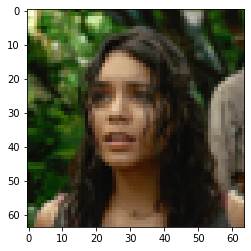

In [16]:
import matplotlib.pyplot as plt
plt.imshow(np.array(img[0][0]))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [112]:
cv2.destroyAllWindows()

In [8]:
df = pd.read_csv("croped_filter_expanded_data.csv")

In [73]:
import cv2
def read_and_resize(filepath, input_shape=(256, 256)):
    im_cv = cv2.imread(filepath)
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    im_means = cv2.mean(im_cv)
    #blob = cv2.dnn.blobFromImage(im, 1, input_shape, im_means)
    im_array = np.array(im, dtype="uint8")#[..., ::-1]
    im_array[0] = im_array[0] - im_means[0]
    im_array[1] = im_array[1] - im_means[1]
    im_array[2] = im_array[2] - im_means[2]

    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")#blob/max(blob)

In [11]:
image = read_and_resize("./Dataset-copy/imdb_faces/imdb_crop/00/nm0000100_rm1264031744_1955-1-6_2007.jpg")

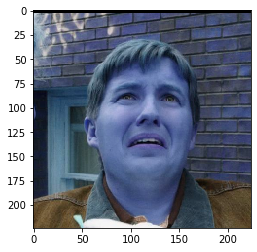

In [69]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [40]:
import numpy as np

In [66]:
import cv2
def read_and_resize(filepath, input_shape=(224,224)):
    im_cv = cv2.imread(filepath)
    im_means = cv2.mean(im_cv)
    im_cv = cv2.resize(im_cv,input_shape)
    #im_cv -= im_means
    a,b,c = (cv2.split(im_cv))
    #im_max = cv2.max(a,b,c)
    im_cv[0] = im_cv[0] - im_means[0]
    im_cv[1] = im_cv[1] - im_means[1]
    im_cv[2] = im_cv[2] - im_means[2]
    im_array = np.array(im_cv)
    im_max = np.max(a)
    im_cv[0] = im_cv[0]/im_max
    im_max = np.max(b)
    im_cv[1] = im_cv[1]/im_max
    im_max = np.max(c)
    im_cv[2] = im_cv[2]/im_max
    return  im_cv

In [67]:
image = read_and_resize("./Dataset-copy/imdb_faces/imdb_crop/20/nm0000120_rm102300416_1962-1-17_2014.jpg")

In [68]:
image.shape

(224, 224, 3)